# Quickstart with CatBoost 🚀🐈 - Binary Classifier
## Install all the things

In [19]:
!pip3 install graphviz
!pip3 install ipywidgets
!pip3 install shap
!pip3 install seaborn

You should consider upgrading via the '/Users/Shared/Dev/learning-stuff/ml/env/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/Shared/Dev/learning-stuff/ml/env/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/Shared/Dev/learning-stuff/ml/env/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/Shared/Dev/learning-stuff/ml/env/bin/python3 -m pip install --upgrade pip' command.


In [20]:
import io
import sys
import json
from time import time
from datetime import datetime, timedelta
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, auc, accuracy_score, roc_auc_score, confusion_matrix, roc_curve

%matplotlib inline

In [21]:
%pip install catboost
from catboost import CatBoostClassifier, Pool
import random

def seed_everything(seed=None):
    if seed is None:
        seed = np.random.randint(100)
    random.seed(seed)
    np.random.seed(seed)
    return seed
seed = seed_everything(42)

You should consider upgrading via the '/Users/Shared/Dev/learning-stuff/ml/env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Lets get some data

In [22]:
from sklearn.datasets import load_iris
import pandas as pd

def load_new_data():
    iris = load_iris()
    df= pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

    df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
    return df

df = load_new_data()
print(df.info())
print(df.species.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   sepal length (cm)  150 non-null    float64 
 1   sepal width (cm)   150 non-null    float64 
 2   petal length (cm)  150 non-null    float64 
 3   petal width (cm)   150 non-null    float64 
 4   target             150 non-null    float64 
 5   species            150 non-null    category
dtypes: category(1), float64(5)
memory usage: 6.3 KB
None
setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64


# Look at the data

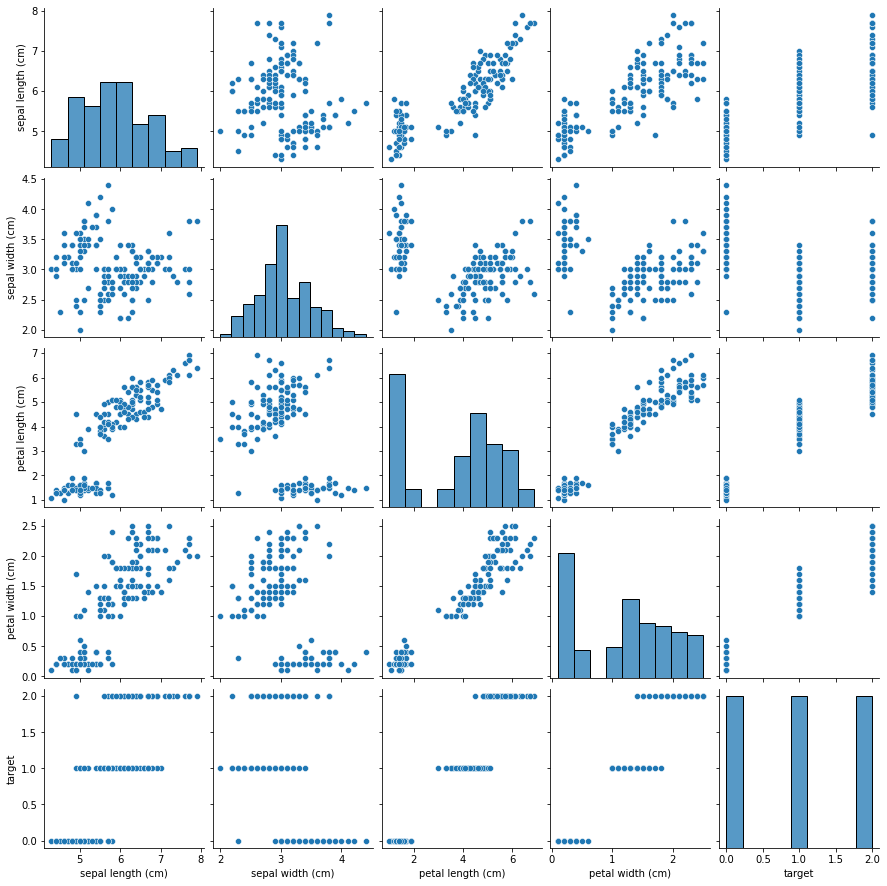

In [23]:
sns.pairplot(df)

# Splitting data and filtering

In [24]:
# all where nan inf or -inf
filter_ = ~(df.isin([np.nan, np.inf, -np.inf]).any(axis=1))
df = df.loc[filter_]

df_tr, df_eval = train_test_split(df)

print("TRAINING")
print(df_tr.head())
print(df_tr.species.value_counts())

print("EVALUATION")
print(df_eval.head())
print(df_eval.species.value_counts())

TRAINING
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
4                  5.0               3.6                1.4               0.2   
32                 5.2               4.1                1.5               0.1   
142                5.8               2.7                5.1               1.9   
85                 6.0               3.4                4.5               1.6   
86                 6.7               3.1                4.7               1.5   

     target     species  
4       0.0      setosa  
32      0.0      setosa  
142     2.0   virginica  
85      1.0  versicolor  
86      1.0  versicolor  
versicolor    39
virginica     38
setosa        35
Name: species, dtype: int64
EVALUATION
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
73                 6.1               2.8                4.7               1.2   
18                 5.7               3.8                1.7               0.3   
118            

## Binary Classifier for the Virginica

In [25]:
X_tr = df_tr
X_eval = df_eval

y_tr = X_tr.species
y_tr_clean = y_tr == 'virginica'
X_tr.drop(columns=['species', 'target'], inplace=True)

y_eval =  X_eval.species
y_eval_clean = y_eval == 'virginica'
X_eval.drop(columns=['species', 'target'], inplace=True)

train_dataset = Pool(df_tr, y_tr_clean, feature_names=list(df_tr.columns))

model_params = {
    'iterations': 10, 
    'loss_function': 'Logloss',
    'train_dir': 'crossentropy',
    'allow_writing_files': False,
    'random_seed': 42,
}

model = CatBoostClassifier(**model_params)
model.fit(train_dataset, verbose=True, plot=True)

Learning rate set to 0.276026


/Users/Shared/Dev/learning-stuff/ml/env/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


0:	learn: 0.5797295	total: 9.5ms	remaining: 85.5ms


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

1:	learn: 0.4916981	total: 15.4ms	remaining: 61.7ms
2:	learn: 0.4090713	total: 17ms	remaining: 39.7ms
3:	learn: 0.3639276	total: 18.6ms	remaining: 28ms
4:	learn: 0.3142213	total: 19.6ms	remaining: 19.6ms
5:	learn: 0.2751339	total: 20.7ms	remaining: 13.8ms
6:	learn: 0.2463971	total: 21.9ms	remaining: 9.38ms
7:	learn: 0.2231012	total: 23.7ms	remaining: 5.93ms
8:	learn: 0.2065240	total: 25.1ms	remaining: 2.79ms
9:	learn: 0.1935820	total: 27ms	remaining: 0us


## Results for Binary Model

In [26]:
import matplotlib.pyplot as plt


predictions = model.predict_proba(X_eval)[:, 1]
THRESH = 0.5           # Set decision threshold

report_dict = classification_report(y_eval_clean, predictions > THRESH, output_dict=True)
report_dict['accuracy'] = accuracy_score(y_eval_clean, predictions > THRESH)
report_dict['confusion'] = confusion_matrix(y_eval_clean, predictions > THRESH).tolist()
fpr, tpr, threshold = roc_curve(y_eval_clean, predictions, drop_intermediate=False)
report_dict['roc_auc'] = auc(fpr, tpr)
report_dict['roc_curve'] = {'fpr': fpr.tolist(), 'tpr': tpr.tolist(), 'threshold': threshold.tolist()}
report_dict['training_features'] = X_tr.columns.to_list()
report_dict['model_features'] = X_tr.columns.to_list()

importances = model.get_feature_importance()
indices = np.argsort(importances)[::-1]
report_dict['feature_importance'] = {X_tr.columns[idx]: float(importances[idx]) for idx in indices}

from IPython.display import JSON
JSON(report_dict)

<IPython.core.display.JSON object>

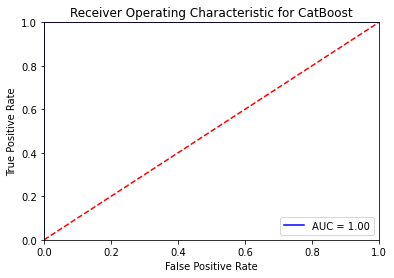

In [27]:
import matplotlib.pyplot as plt


plt.title('Receiver Operating Characteristic for CatBoost')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % report_dict['roc_auc'])
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


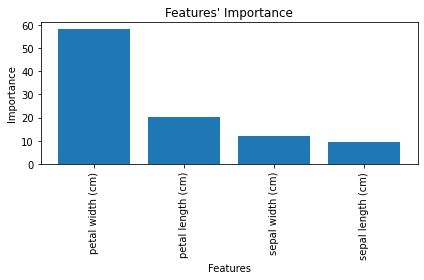

In [30]:
feat_imp_index = report_dict['feature_importance'].keys()
feat_imp_vals = report_dict['feature_importance'].values()

plt.title("Features' Importance")
plt.bar(feat_imp_index, feat_imp_vals)
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()